Research Paper : https://arxiv.org/pdf/2402.06689

# Data Loading

[*********************100%***********************]  1 of 1 completed


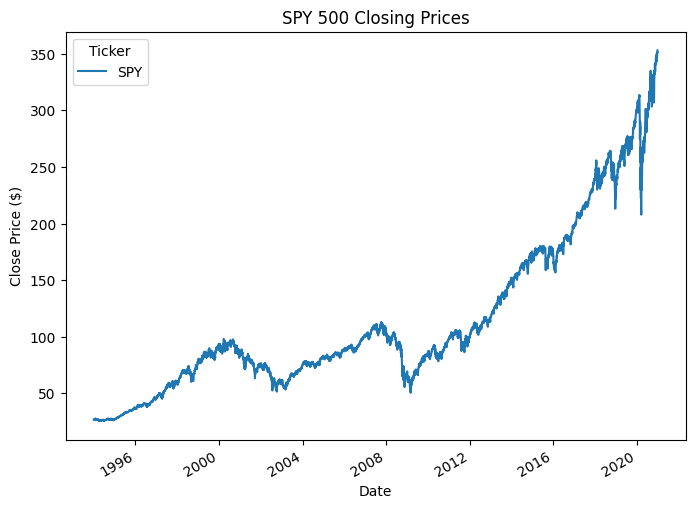

Data successfully loaded and preprocessed!
(6799, 5)
Price            Open       High        Low      Close  Volume
Ticker            SPY        SPY        SPY        SPY     SPY
Date                                                          
1994-01-03  26.662089  26.697853  26.554797  26.590561  960900
1994-01-04  26.626331  26.697859  26.590567  26.697859  164300
1994-01-05  26.733625  26.769389  26.626333  26.751507  710900
1994-01-06  26.787271  26.805153  26.715743  26.751507  201000
1994-01-07  26.805159  26.930333  26.733631  26.912451  775500


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Retrieve SPY 500 ETF Data from Yahoo Finance
# Long plot | def load_data(symbol="SPY", start="1994-01-01", end="2019-09-30"):
# Test data | def load_data(symbol="SPY", start="2019-01-01", end="2020-09-03"):
# Test data Day N° |    +- 6525 = 2019-11-30     +- 6950 = 2021-07-30     # Number of days on the x axis don't match plot dates

def load_data(symbol="SPY", start="1994-01-01", end="2021-01-01"):
    df = yf.download(symbol, start=start, end=end)
    df.reset_index(inplace=True)
    return df

# Preprocess Data
def preprocess_data(df):
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.dropna(inplace=True)  # Remove any missing values
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Load and Prepare Data
df = load_data()
df = preprocess_data(df)

# Plot Closing Prices
df['Close'].plot(figsize=(8,6), title="SPY 500 Closing Prices", xlabel="Date", ylabel="Close Price ($)")
plt.show()

print("Data successfully loaded and preprocessed!")
print(df.shape)
print(df.head())

# Datasets Preparation

In [3]:
# Split into Training & Testing
train_data = df.loc["1994-01-01":"2018-12-31"]
test_data = df.loc["2019-01-01":"2020-09-03"]

# Normalize the Data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])

# Usual Models

Running Naïve Forecast...


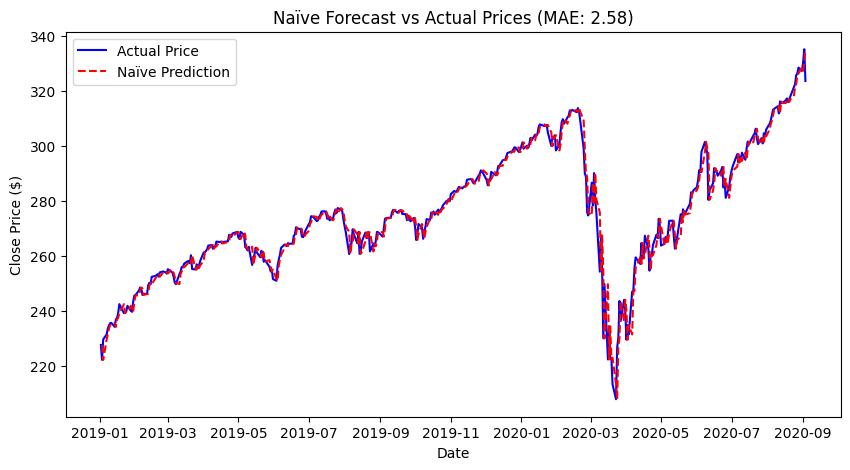

Naïve Approach MAE: 2.58


In [4]:
# ===================== 1. Naïve Approach ===================== #
def naive_forecast(test_data):
    naive_predictions = test_data['Close'].shift(1)  # Previous day's price
    naive_mae = mean_absolute_error(test_data['Close'][1:], naive_predictions[1:])

    plt.figure(figsize=(10,5))
    plt.plot(test_data.index, test_data['Close'], label="Actual Price", color="blue")
    plt.plot(test_data.index, naive_predictions, label="Naïve Prediction", color="red", linestyle="dashed")
    plt.title(f"Naïve Forecast vs Actual Prices (MAE: {naive_mae:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price ($)")
    plt.legend()
    plt.show()

    print(f"Naïve Approach MAE: {naive_mae:.2f}")
    return naive_mae

print("Running Naïve Forecast...")
naive_mae = naive_forecast(test_data)


Running Moving Average Forecast (5-day)...


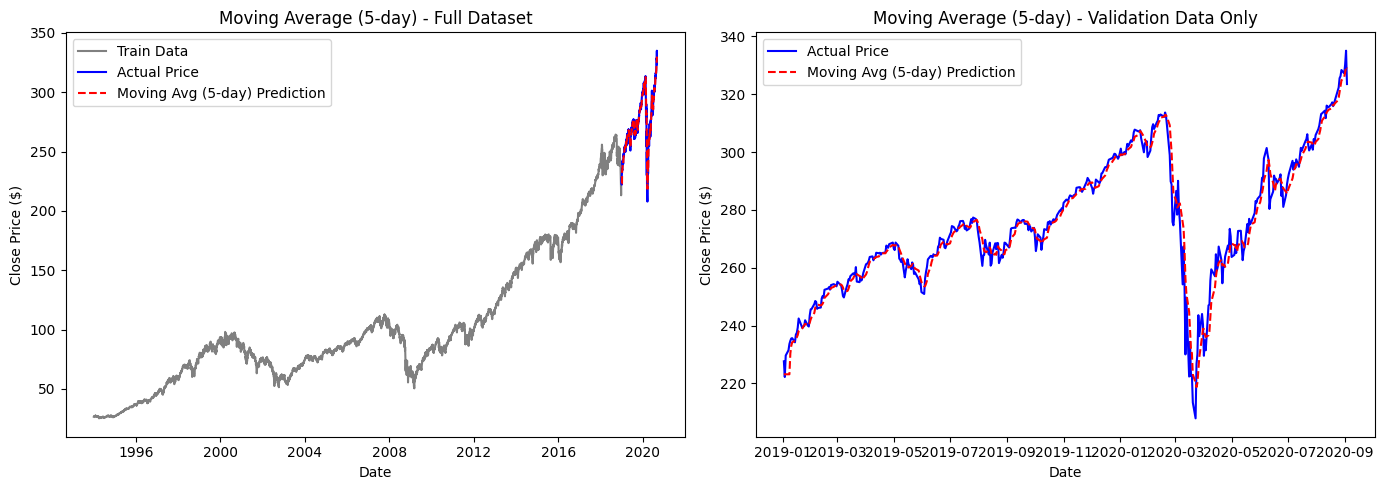

Moving Average (5-day) MAE: 2.67

Running Moving Average Forecast (20-day)...


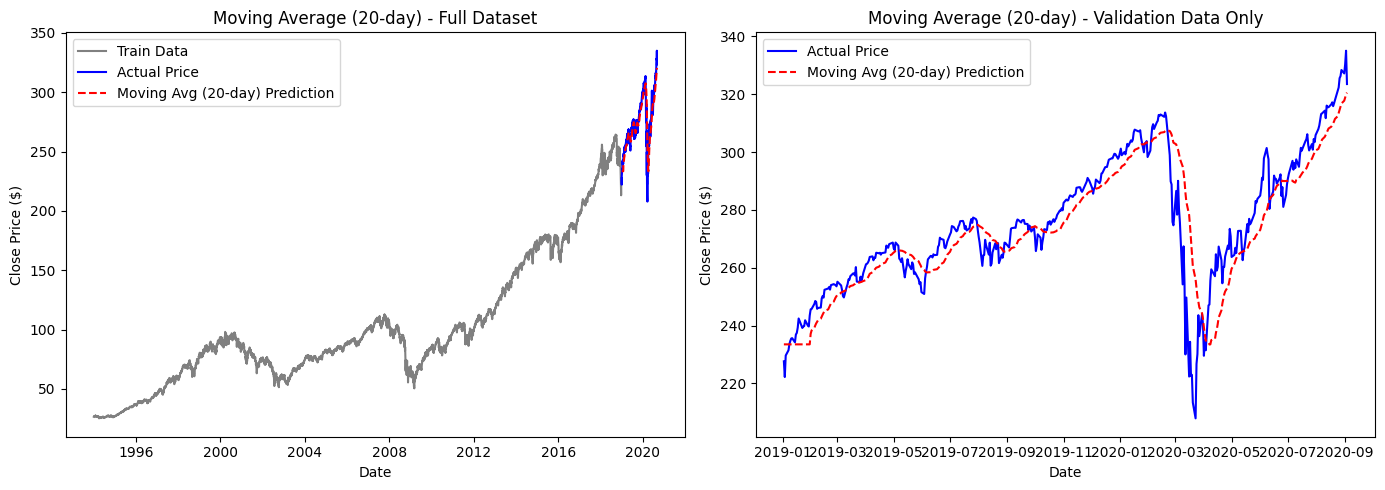

Moving Average (20-day) MAE: 7.04


In [5]:
# ===================== 2. Moving Average Model ===================== #
def moving_average_forecast(train_data, test_data, window):
    moving_avg = train_data['Close'].rolling(window=window).mean().dropna()
    last_moving_avg = moving_avg.iloc[-1]

    test_predictions = test_data['Close'].rolling(window=window).mean()
    test_predictions.iloc[:window] = last_moving_avg

    test_mae = mean_absolute_error(test_data['Close'][window:], test_predictions[window:])

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Full Dataset Visualization
    axs[0].plot(train_data.index, train_data['Close'], label="Train Data", color="gray")
    axs[0].plot(test_data.index, test_data['Close'], label="Actual Price", color="blue")
    axs[0].plot(test_data.index, test_predictions, label=f"Moving Avg ({window}-day) Prediction", color="red", linestyle="dashed")
    axs[0].set_title(f"Moving Average ({window}-day) - Full Dataset")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Close Price ($)")
    axs[0].legend()

    # Focused Validation Data Plot
    axs[1].plot(test_data.index, test_data['Close'], label="Actual Price", color="blue")
    axs[1].plot(test_data.index, test_predictions, label=f"Moving Avg ({window}-day) Prediction", color="red", linestyle="dashed")
    axs[1].set_title(f"Moving Average ({window}-day) - Validation Data Only")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Close Price ($)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"Moving Average ({window}-day) MAE: {test_mae:.2f}")
    return test_mae

print("\nRunning Moving Average Forecast (5-day)...")
ma5_mae = moving_average_forecast(train_data, test_data, window=5)

print("\nRunning Moving Average Forecast (20-day)...")
ma20_mae = moving_average_forecast(train_data, test_data, window=20)



Running Rolling ARIMA Forecast (order=(2,1,2))...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


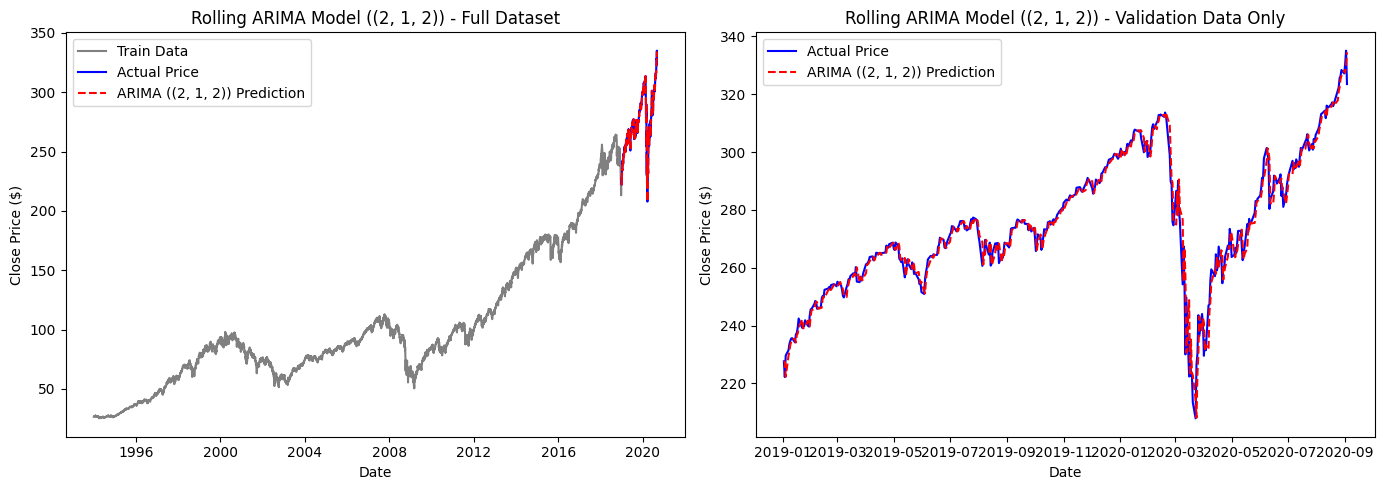

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

def arima_forecast_rolling(train_data, test_data, order=(2,1,2)):
    history = train_data['Close'].squeeze().tolist()
    predictions = []

    for t in range(len(test_data)):
        try:
            history_series = pd.Series(history)
            history_series.index = pd.date_range(start=train_data.index[0], periods=len(history), freq='B')

            model = ARIMA(history_series, order=order)
            model_fit = model.fit(method_kwargs={"maxiter": 500})

            next_pred = model_fit.forecast().iloc[0]
            predictions.append(next_pred)

            test_value = test_data['Close'].iloc[t]
            if isinstance(test_value, pd.Series):
                test_value = test_value['SPY']
            history.append(test_value)

        except Exception as e:
            print(f"❌ Error at step {t}: {e}")
            return None, None

    arima_mae = mean_absolute_error(test_data['Close'], predictions)

    # Create Side-by-Side Plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Full Dataset Visualization
    axs[0].plot(train_data.index, train_data['Close'], label="Train Data", color="gray")
    axs[0].plot(test_data.index, test_data['Close'], label="Actual Price", color="blue")
    axs[0].plot(test_data.index, predictions, label=f"ARIMA ({order}) Prediction", color="red", linestyle="dashed")
    axs[0].set_title(f"Rolling ARIMA Model ({order}) - Full Dataset")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Close Price ($)")
    axs[0].legend()

    # Focused Validation Data Plot
    axs[1].plot(test_data.index, test_data['Close'], label="Actual Price", color="blue")
    axs[1].plot(test_data.index, predictions, label=f"ARIMA ({order}) Prediction", color="red", linestyle="dashed")
    axs[1].set_title(f"Rolling ARIMA Model ({order}) - Validation Data Only")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Close Price ($)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return arima_mae, predictions

print("\nRunning Rolling ARIMA Forecast (order=(2,1,2))...")
arima_mae, arima_predictions = arima_forecast_rolling(train_data, test_data, order=(2,1,2))


# Deep Learning Models

In [7]:
def create_sequences(data, seq_length=30, reshape=True):
    """
    Generalized function to create sequences for any model.

    Parameters:
    - data (numpy array): Scaled time-series data.
    - seq_length (int): Number of past days used for prediction.
    - reshape (bool): If True, reshapes to (samples, timesteps, features).

    Returns:
    - X (numpy array): Input sequences.
    - y (numpy array): Corresponding target values.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])  # Predict the next value

    X, y = np.array(X), np.array(y)

    # Reshape for RNN/LSTM/CNN models
    if reshape:
        X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y


For RNN

In [8]:
# ===================== 4. RNN Model ===================== #
X_train, y_train = create_sequences(train_scaled, 30)
X_test, y_test = create_sequences(test_scaled, 30)

print("RNN Training set shape:", X_train.shape, y_train.shape)
print("RNN Testing set shape:", X_test.shape, y_test.shape)


RNN Training set shape: (6264, 30, 1) (6264, 1)
RNN Testing set shape: (393, 30, 1) (393, 1)


In [9]:
def build_rnn_vector(seq_length):
    model = Sequential([
        SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)),
        Dense(1)  # Output single value
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0124 - val_loss: 3.5089e-04
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9400e-05 - val_loss: 4.2547e-04
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4650e-05 - val_loss: 3.2277e-04
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.2512e-05 - val_loss: 3.4375e-04
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.8197e-05 - val_loss: 4.5057e-04
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.1149e-05 - val_loss: 4.5918e-04
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0242e-05 - val_loss: 3.6458e-04
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1062e-05 - val_loss: 3.3529e-04
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.1012e-05 - val_loss: 5.5943e-04
Epoch 10/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7580e-05 - val_loss: 5.0644e-04
Epoch 11/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3

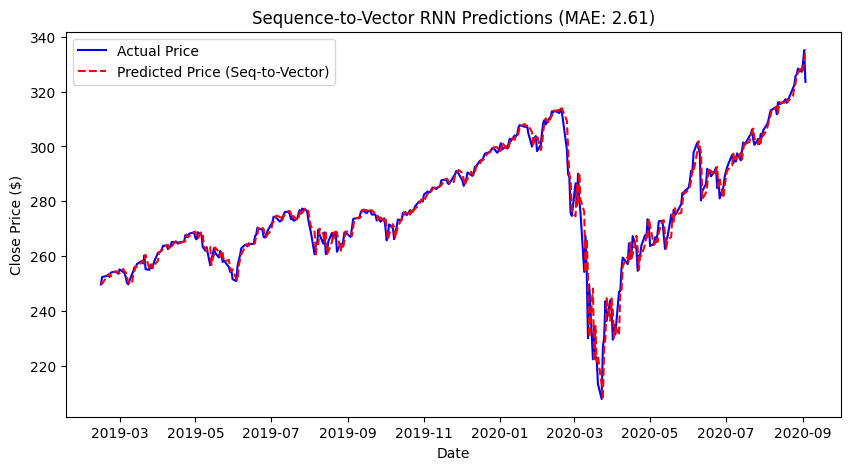

In [10]:
# Train RNN Sequence-to-Vector Model
rnn_vector = build_rnn_vector(30)
history_vector = rnn_vector.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_vector = rnn_vector.predict(X_test)
y_pred_vector_rescaled = scaler.inverse_transform(y_pred_vector)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Evaluate MAE
mae_rnn_vector = mean_absolute_error(y_test_rescaled, y_pred_vector_rescaled)
print(f"Sequence-to-Vector RNN MAE: {mae_rnn_vector:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[30:], y_test_rescaled, label="Actual Price", color="blue")
plt.plot(test_data.index[30:], y_pred_vector_rescaled, label="Predicted Price (Seq-to-Vector)", color="red", linestyle="dashed")
plt.title(f"Sequence-to-Vector RNN Predictions (MAE: {mae_rnn_vector:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()


In [11]:
def build_rnn_seq2seq(seq_length):
    model = Sequential([
        SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        SimpleRNN(50, activation='relu', return_sequences=False),  # Final RNN layer outputs vector
        Dense(seq_length)  # Predict a sequence of `seq_length` days
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0353 - val_loss: 0.0011
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1725e-04 - val_loss: 0.0013
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2629e-04 - val_loss: 8.3793e-04
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7387e-05 - val_loss: 0.0014
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5160e-05 - val_loss: 0.0015
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8278e-05 - val_loss: 8.7216e-04
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7291e-05 - val_loss: 8.2340e-04
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9384e-05 - val_loss: 0.0019
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9493e-05 - val_loss: 8.2819e-04
Epoch 10/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7369e-05 - val_loss: 4.7694e-04
Epoch 11/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.2225e-05 - val_loss: 6.3435e-0

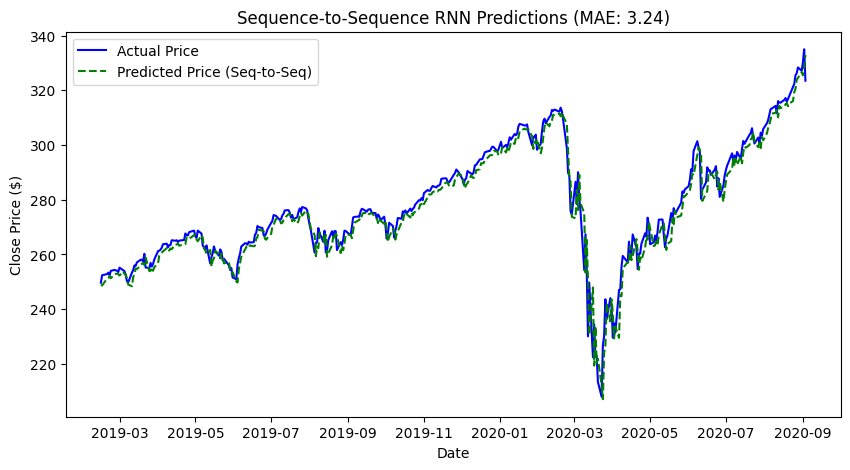

In [12]:
# Train RNN Sequence-to-Sequence Model
rnn_seq2seq = build_rnn_seq2seq(30)
history_seq2seq = rnn_seq2seq.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_seq2seq = rnn_seq2seq.predict(X_test)
y_pred_seq2seq_rescaled = scaler.inverse_transform(y_pred_seq2seq)
y_test_rescaled_seq = scaler.inverse_transform(y_test.reshape(-1,1))

# Evaluate MAE
mae_rnn_seq2seq = mean_absolute_error(y_test_rescaled_seq, y_pred_seq2seq_rescaled[:, -1])
print(f"Sequence-to-Sequence RNN MAE: {mae_rnn_seq2seq:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[30:], y_test_rescaled_seq, label="Actual Price", color="blue")
plt.plot(test_data.index[30:], y_pred_seq2seq_rescaled[:, -1], label="Predicted Price (Seq-to-Seq)", color="green", linestyle="dashed")
plt.title(f"Sequence-to-Sequence RNN Predictions (MAE: {mae_rnn_seq2seq:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()


For LSTM

In [13]:
# ===================== 5. LSTM Model ===================== #
# 20-day window
X_train_20, y_train_20 = create_sequences(train_scaled, 20)
X_test_20, y_test_20 = create_sequences(test_scaled, 20)

# 30-day window
X_train_30, y_train_30 = create_sequences(train_scaled, 30)
X_test_30, y_test_30 = create_sequences(test_scaled, 30)

print("20-day Training set shape:", X_train_20.shape, y_train_20.shape)
print("30-day Training set shape:", X_train_30.shape, y_train_30.shape)


20-day Training set shape: (6274, 20, 1) (6274, 1)
30-day Training set shape: (6264, 30, 1) (6264, 1)


In [14]:
def build_lstm(seq_length):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50, activation='relu', return_sequences=False),
        Dense(1)  # Predict a single value
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0157 - val_loss: 0.0020
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.3840e-04 - val_loss: 0.0018
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3812e-04 - val_loss: 0.0016
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2671e-04 - val_loss: 0.0016
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2582e-04 - val_loss: 0.0018
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0585e-04 - val_loss: 0.0021
Epoch 7/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2057e-04 - val_loss: 0.0013
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.4552e-05 - val_loss: 0.0046
Epoch 9/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3439e-04 - val_loss: 0.0016
Epoch 10/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.4831e-05 - val_loss: 0.0023
Epoch 11/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.2826e-05 - val_loss: 7.0698e-04
Epoch 12/50
393/3

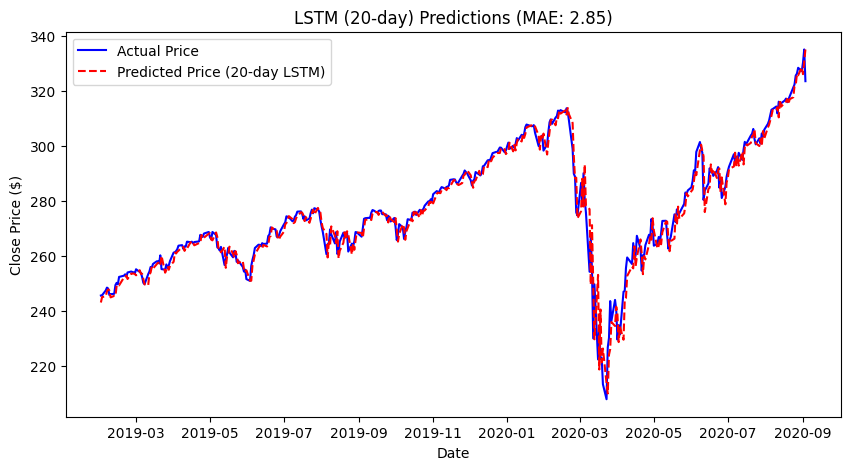

In [15]:
# Train LSTM (20-day window)
lstm_20 = build_lstm(20)
history_20 = lstm_20.fit(X_train_20, y_train_20, epochs=50, batch_size=16, validation_data=(X_test_20, y_test_20), verbose=1)

# Predictions
y_pred_20 = lstm_20.predict(X_test_20)
y_pred_20_rescaled = scaler.inverse_transform(y_pred_20)
y_test_20_rescaled = scaler.inverse_transform(y_test_20.reshape(-1,1))

# Evaluate MAE
mae_lstm_20 = mean_absolute_error(y_test_20_rescaled, y_pred_20_rescaled)
print(f"LSTM (20-day) MAE: {mae_lstm_20:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[20:], y_test_20_rescaled, label="Actual Price", color="blue")
plt.plot(test_data.index[20:], y_pred_20_rescaled, label="Predicted Price (20-day LSTM)", color="red", linestyle="dashed")
plt.title(f"LSTM (20-day) Predictions (MAE: {mae_lstm_20:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0275 - val_loss: 0.0032
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.4796e-04 - val_loss: 0.0023
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.4512e-04 - val_loss: 0.0025
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.4298e-04 - val_loss: 0.0023
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3159e-04 - val_loss: 0.0016
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.2593e-04 - val_loss: 0.0014
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.1035e-04 - val_loss: 0.0014
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0618e-04 - val_loss: 0.0013
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4014e-04 - val_loss: 9.0239e-04
Epoch 10/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.4669e-05 - val_loss: 8.9240e-04
Epoch 11/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.5888e-05 - val_loss: 0.0016
Epoch 12/50
3

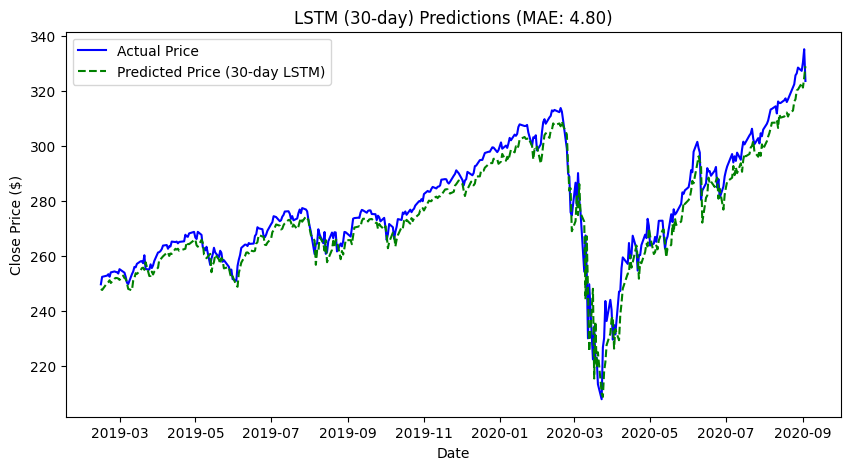

In [16]:
# Train LSTM (30-day window)
lstm_30 = build_lstm(30)
history_30 = lstm_30.fit(X_train_30, y_train_30, epochs=50, batch_size=16, validation_data=(X_test_30, y_test_30), verbose=1)

# Predictions
y_pred_30 = lstm_30.predict(X_test_30)
y_pred_30_rescaled = scaler.inverse_transform(y_pred_30)
y_test_30_rescaled = scaler.inverse_transform(y_test_30.reshape(-1,1))

# Evaluate MAE
mae_lstm_30 = mean_absolute_error(y_test_30_rescaled, y_pred_30_rescaled)
print(f"LSTM (30-day) MAE: {mae_lstm_30:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[30:], y_test_30_rescaled, label="Actual Price", color="blue")
plt.plot(test_data.index[30:], y_pred_30_rescaled, label="Predicted Price (30-day LSTM)", color="green", linestyle="dashed")
plt.title(f"LSTM (30-day) Predictions (MAE: {mae_lstm_30:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()


For CNN

In [17]:
# ===================== 6. CNN Model ===================== #
X_train_cnn, y_train_cnn = create_sequences(train_scaled, 30)
X_test_cnn, y_test_cnn = create_sequences(test_scaled, 30)

print("CNN Training set shape:", X_train_cnn.shape, y_train_cnn.shape)
print("CNN Testing set shape:", X_test_cnn.shape, y_test_cnn.shape)


CNN Training set shape: (6264, 30, 1) (6264, 1)
CNN Testing set shape: (393, 30, 1) (393, 1)


In [18]:
def build_preprocess_cnn(seq_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)  # Predict a single value
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4174e-04 - val_loss: 0.0022
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7178e-04 - val_loss: 0.0013
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0468e-04 - val_loss: 0.0014
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2537e-04 - val_loss: 9.9075e-04
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3363e-04 - val_loss: 0.0073
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9968e-04 - val_loss: 7.7140e-04
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8340e-05 - val_loss: 7.3948e-04
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8540e-05 - val_loss: 0.0022
Epoch 10/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9242e-05 - val_loss: 0.0012
Epoch 11/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0708e-04 - val_loss: 0.0012
Epoch 12/50

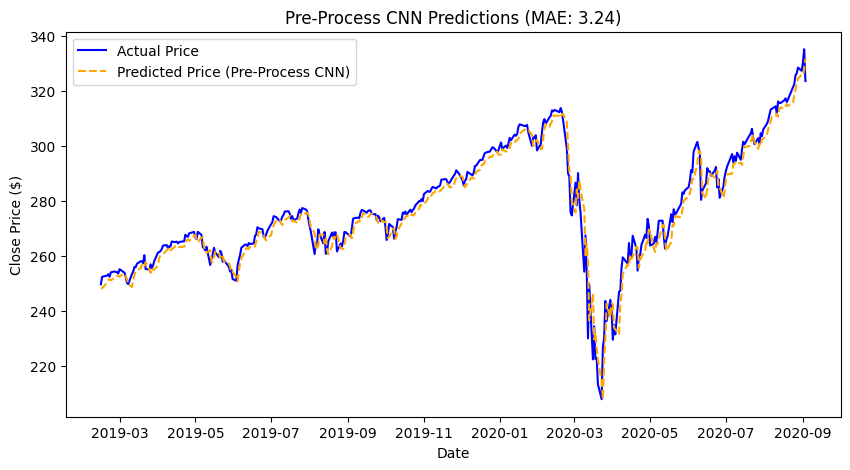

In [19]:
# Train Pre-Process CNN
cnn_preprocess = build_preprocess_cnn(30)
history_preprocess = cnn_preprocess.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=16, validation_data=(X_test_cnn, y_test_cnn), verbose=1)

# Predictions
y_pred_cnn_preprocess = cnn_preprocess.predict(X_test_cnn)
y_pred_cnn_preprocess_rescaled = scaler.inverse_transform(y_pred_cnn_preprocess)
y_test_cnn_preprocess_rescaled = scaler.inverse_transform(y_test_cnn.reshape(-1,1))

# Evaluate MAE
mae_cnn_preprocess = mean_absolute_error(y_test_cnn_preprocess_rescaled, y_pred_cnn_preprocess_rescaled)
print(f"Pre-Process CNN MAE: {mae_cnn_preprocess:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[30:], y_test_cnn_preprocess_rescaled, label="Actual Price", color="blue")
plt.plot(test_data.index[30:], y_pred_cnn_preprocess_rescaled, label="Predicted Price (Pre-Process CNN)", color="orange", linestyle="dashed")
plt.title(f"Pre-Process CNN Predictions (MAE: {mae_cnn_preprocess:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()


In [20]:
def build_full_cnn(seq_length):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, dilation_rate=1, activation='relu', input_shape=(seq_length, 1)),
        Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu'),
        Conv1D(filters=128, kernel_size=3, dilation_rate=4, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Predict a single value
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 10/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 11/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 12/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0

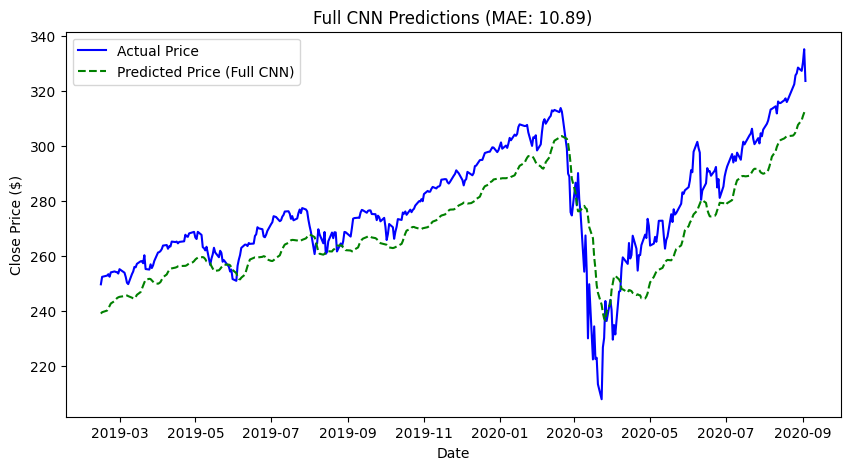

In [21]:
# Train Full CNN (WaveNet)
cnn_full = build_full_cnn(30)
history_full = cnn_full.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=16, validation_data=(X_test_cnn, y_test_cnn), verbose=1)

# Predictions
y_pred_cnn_full = cnn_full.predict(X_test_cnn)
y_pred_cnn_full_rescaled = scaler.inverse_transform(y_pred_cnn_full)
y_test_cnn_full_rescaled = scaler.inverse_transform(y_test_cnn.reshape(-1,1))

# Evaluate MAE
mae_cnn_full = mean_absolute_error(y_test_cnn_full_rescaled, y_pred_cnn_full_rescaled)
print(f"Full CNN (WaveNet) MAE: {mae_cnn_full:.2f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(test_data.index[30:], y_test_cnn_full_rescaled, label="Actual Price", color="blue")
plt.plot(test_data.index[30:], y_pred_cnn_full_rescaled, label="Predicted Price (Full CNN)", color="green", linestyle="dashed")
plt.title(f"Full CNN Predictions (MAE: {mae_cnn_full:.2f})")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()

Results

In [22]:
# ===================== Summary of Results ===================== #
results = {
    "Naïve": naive_mae,
    "Moving Avg (5-day)": ma5_mae,
    "Moving Avg (20-day)": ma20_mae,
    "ARIMA (1,1,1)": arima_mae,
    "RNN Sequence 2 Vector" : mae_rnn_vector,
    "RNN Sequence 2 Sequence" : mae_rnn_seq2seq,
    "LSTM (20-day)": mae_lstm_20,
    "LSTM (30-day)": mae_lstm_30,
    "Pre-Process CNN": mae_cnn_preprocess,
    "Full CNN (WaveNet Architecture)": mae_cnn_full
}

print("\nFinal MAE Results:")
for model, mae in results.items():
    print(f"{model}: {mae:.2f}")



Final MAE Results:
Naïve: 2.58
Moving Avg (5-day): 2.67
Moving Avg (20-day): 7.04
ARIMA (1,1,1): 2.56
RNN Sequence 2 Vector: 2.61
RNN Sequence 2 Sequence: 3.24
LSTM (20-day): 2.85
LSTM (30-day): 4.80
Pre-Process CNN: 3.24
Full CNN (WaveNet Architecture): 10.89


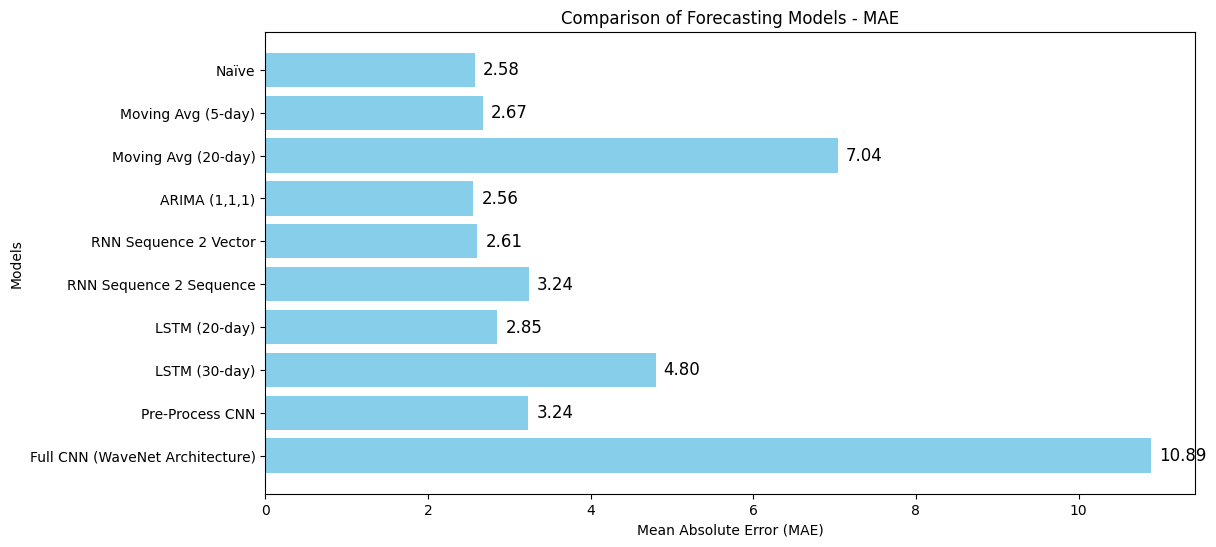

In [23]:
models = list(results.keys())
mae_values = list(results.values())

plt.figure(figsize=(12, 6))
plt.barh(models, mae_values, color='skyblue')

for index, value in enumerate(mae_values):
    plt.text(value + 0.1, index, f"{value:.2f}", va='center', fontsize=12)

plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Models")
plt.title("Comparison of Forecasting Models - MAE")
plt.gca().invert_yaxis()
plt.show()
